In [1]:
import dask
from dask.distributed import Client, LocalCluster
import xarray as xr
import numpy as np
import  matplotlib.pyplot as plt
import os
from ipywidgets import Image
from ipywidgets import ColorPicker, IntSlider, link, AppLayout, HBox
from ipycanvas import  hold_canvas,  MultiCanvas #RoughCanvas,Canvas,
import imageio

In [2]:
cluster = LocalCluster() 
client = Client(cluster)
print('Dashboard at '+cluster.dashboard_link)

2022-08-19 15:42:59,111 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-iclogshf', purging
2022-08-19 15:42:59,111 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-pjwf1hsa', purging
2022-08-19 15:42:59,111 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-3m3gmghl', purging


Dashboard at http://127.0.0.1:8787/status


In [3]:
from filter_functions import image_filter

In [4]:
from training_functions import train_segmentation

In [5]:
def on_mouse_down(x, y):
    global drawing
    global position
    global shape
    drawing = True
    position = (x, y)
    shape = [position]

def on_mouse_move(x, y):
    global drawing
    global position
    global shape
    if not drawing:
        return
    with hold_canvas():
        canvas.stroke_line(position[0], position[1], x, y)
        position = (x, y)
    shape.append(position)

def on_mouse_up(x, y):
    global drawing
    global positiondu
    global shape
    drawing = False
    with hold_canvas():
        canvas.stroke_line(position[0], position[1], x, y)
        canvas.fill_polygon(shape)
    shape = []

In [6]:
path = '/home/fische_r/NAS/testing/Jeremy_tomo/tomodata.nc'
featpath = '/home/fische_r/NAS/testing/Jeremy_tomo/featdata.nc'
# path = r"C:\Zwischenlager\tomodata.nc"
# path = '/mpc/homes/fische_r/jeremy/tomodata.nc'

In [7]:
IF = image_filter(data_path=path, outpath = featpath)

In [8]:
IF.open_raw_data()

In [9]:
# IF.data

In [10]:
IF.prepare()

In [11]:
IF.stack_features()

In [12]:
# IF.feature_stack

In [13]:
IF.compute() #not sure what is more efficient, but I would compute the features and even store them on disk
# had the impression that otherwise many redundant operations happen

In [14]:
# IF.make_xarray_nc()

In [21]:
IF.make_xarray_nc()

In [25]:
test = IF.feature_stack.rechunk(IF.outchunks)

In [26]:
test

dask.array<rechunk-merge, shape=(200, 39, 233, 8, 73), dtype=float64, chunksize=(50, 39, 233, 8, 9), chunktype=numpy.ndarray>

In [28]:
IF.result['feature_stack'] = (['x','y','z','time','feature'],test)

In [ ]:
IF.result.to_netcdf(featpath)

Task exception was never retrieved
future: <Task finished name='Task-595992' coro=<Client._gather.<locals>.wait() done, defined at /home/fische_r/miniconda3/lib/python3.9/site-packages/distributed/client.py:2003> exception=AllExit()>
Traceback (most recent call last):
  File "/home/fische_r/miniconda3/lib/python3.9/site-packages/distributed/client.py", line 2012, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-595993' coro=<Client._gather.<locals>.wait() done, defined at /home/fische_r/miniconda3/lib/python3.9/site-packages/distributed/client.py:2003> exception=AllExit()>
Traceback (most recent call last):
  File "/home/fische_r/miniconda3/lib/python3.9/site-packages/distributed/client.py", line 2012, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-595994' coro=<Client._gather.<locals>.wait() done, defined at /home/fische_r/miniconda3/l

In [17]:
# training_path = r"C:\Zwischenlager\Jeremy_tomo"
training_path = '/home/fische_r/NAS/testing/Jeremy_tomo'
training_path = '/mpc/homes/fische_r/jeremy'
if not os.path.exists(training_path):
    os.mkdir(training_path)

In [1]:
1

1

In [18]:
TS = train_segmentation(training_path=training_path)

In [19]:
# TS.import_lazy_feature_stack(IF.result)

In [20]:
# TS.feat_data = IF.result

In [21]:
# TS.feature_names = TS.feat_data['feature'].data

In [22]:
# TS.import_lazy_feature_data(IF.result)

In [23]:
TS.import_feature_data(IF.result)

### iterative training, if you have a training set, skip here

In [24]:
TS.suggest_training_set()

You could try  y = 6  and  z = 132
However, please sort it like the original xyztime


In [33]:
c1 = 'y'
p1 = 10
c2 = 'time'
p2 = 3

In [34]:
TS.load_training_set(c1, p1, c2, p2)

existing label set loaded


In [35]:
# TS.interface()

In [36]:
# TS.current_im8 = TS.current_im8.compute()

In [40]:
alpha = 0.15
im8 = TS.current_im8
resultim = TS.current_result
width = im8.shape[1]
height = im8.shape[0]
Mcanvas = MultiCanvas(4, width=width, height=height)
background = Mcanvas[0]
resultdisplay = Mcanvas[2]
truthdisplay = Mcanvas[1]
canvas = Mcanvas[3]
canvas.sync_image_data = True
drawing = False
position = None
shape = []
image_data = np.stack((im8, im8, im8), axis=2)
background.put_image_data(image_data, 0, 0)
resultdisplay.global_alpha = alpha
if np.any(resultim>0):
    result_data = np.stack((255*(resultim==0), 255*(resultim==1), 255*(resultim==2)), axis=2)
else:
    result_data = np.stack((0*resultim, 0*resultim, 0*resultim), axis=2)
resultdisplay.put_image_data(result_data, 0, 0)
canvas.on_mouse_down(on_mouse_down)
canvas.on_mouse_move(on_mouse_move)
canvas.on_mouse_up(on_mouse_up)
picker = ColorPicker(description="Color:", value="#ff0000")
slidealpha = IntSlider(description="Result overlay", value=0.15)
link((picker, "value"), (canvas, "stroke_style"))
link((picker, "value"), (canvas, "fill_style"))
HBox((Mcanvas, picker, slidealpha))

In [38]:
label_set = canvas.get_image_data()

TS.current_truth[label_set[:,:,0]>0] = 1
TS.current_truth[label_set[:,:,1]>0] = 2
TS.current_truth[label_set[:,:,2]>0] = 4

imageio.imsave(TS.current_truthpath, TS.current_truth)

In [39]:
TS.train_slice()

training and classifying


### when done, maybe save the classifier

In [38]:
# TS.pickle_classifier()

### use an existing trainingset to train classifier (adhere to label iamge naming convention)

In [24]:
# TS.feat_data = TS.feat_data.compute() #better option for retraining, but creates a numpy array, maybe you can avoid

In [25]:
# provide new feature data if necessary and say if it is a lazy dask array or not
# TS.feat_data = 
# TS.lazy = 

TS.train()

In [26]:
# TS.pickle_classifier()

In [27]:
from segmentation import segmentation

In [28]:
SM = segmentation(training_path = training_path)

In [29]:
SM.import_classifier(TS.clf)

In [30]:
SM.import_feature_data(IF.result)

In [31]:
# SM.lazy = False

In [32]:
SM.classify_all()

classifying ...


In [33]:
SM.store_segmented_data()

NameError: name 'shp' is not defined

In [38]:
path = os.path.join(SM.training_path, 'segmented.nc')

#TODO: propagate labels from raw data
#TODO: if self.segmented_data is a dask array, rechunk for saving
shp = SM.segmented_data.shape
data = xr.Dataset({'segmented': (['x','y','z','time'], SM.segmented_data)},
                               coords = {'x': np.arange(shp[0]),
                               'y': np.arange(shp[1]),
                               'z': np.arange(shp[2]),
                               'time': np.arange(shp[3]),
                               'feature': SM.feature_names}
                     )
data.to

AttributeError: 'Dataset' object has no attribute 'to_netcdf4'

In [41]:
data.to_netcdf(path)

In [42]:
TS.plot_importance()

NameError: name 'sigsize' is not defined

/tmp/ipykernel_643997/3278944968.py:2: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  plt.stem(TS.feature_names, TS.clf.feature_importances_,'x')


Text(0, 0.5, 'importance')

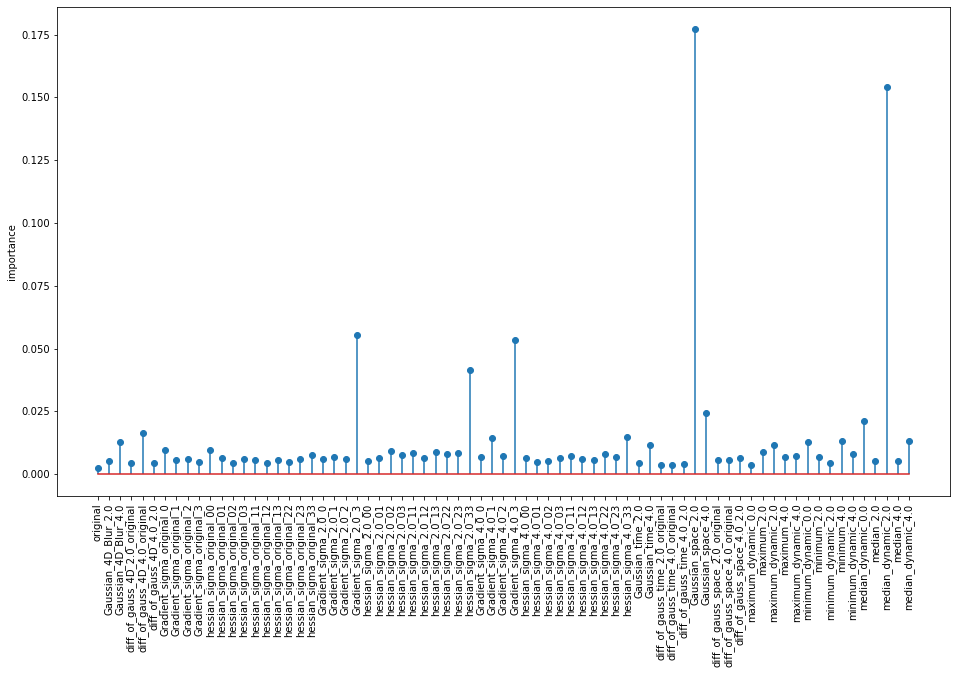

In [45]:
plt.figure(figsize=(16,9))
plt.stem(TS.feature_names, TS.clf.feature_importances_,'x')
plt.xticks(rotation=90)
plt.ylabel('importance') 

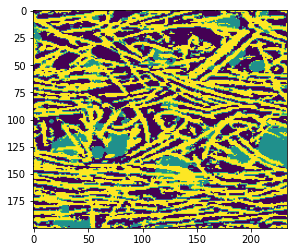

In [49]:
plt.imshow(SM.segmented_data[:,10,:,-1])